# Perform pFBA
Author: Diana Szeliova \
Last update: 15.7.2024

* pFBA for three experimental conditions: Low cell density, High cell density and Overfeeding
* constraints: uptake and secretion rates, minimum NGAM (non-growth associated mainenance energy) from https://doi.org/10.1371/journal.pone.0043401

In [1]:
import pickle
import cobra
import pandas as pd
import matplotlib.pyplot as plt
from model_class import (Model, plot_sampling,
                         get_central_fluxes)

# Define global figure parameters
%matplotlib inline
plt.rcParams.update({'font.size': 15})
plt.rcParams['figure.figsize'] = [10, 6]

## Constants

In [2]:
NGAM = 1.9
N_SAMPLES = 1000
conditions = {"Low Cell Density": "low",
              "High Cell Density": "high",
              "Overfeeding": "overfeeding"}

## Read data

In [3]:
with open('../data/sulfolobus_reaction_ids.pkl', 'rb') as fp:
    reaction_ids = pickle.load(fp)
with open('../data/processed_rates.pkl', 'rb') as fp:
    rates = pickle.load(fp)

In [4]:
# model
cobra_model = cobra.io.read_sbml_model("../data/Sulfolobus-solfataricus_corrected.xml")
cobra_model.solver = "cplex"

In [5]:
# reactions to extract
central_metabolism = pd.read_csv("../data/Sulfolobus_central_metabolism.csv")

In [6]:
unique_rxn_ids = []
for index, row in central_metabolism.iterrows():
    if row.ID != row.ID:
        unique_rxn_ids.append("")
        continue

    unique_rxn_ids.append(str(row.ID).split(", ")[0])
central_metabolism["unique_ID"] = unique_rxn_ids

## Functions

In [7]:
def set_common_bounds(model, NGAM):
    """
    set bounds on some specific reactions
    """
    common_bounds = {"198": (0, 0),  # hexokinase - no gene
                     "5": (NGAM, NGAM),  # non-growth maintenance energy
                     "133": (-1000, 1000)}  # trehalose transport reversible
    for rxn, bound in common_bounds.items():
        model.set_lower_bound(rxn, bound[0])
        model.set_upper_bound(rxn, bound[1])

## pFBA - maximize biomass
* upper and lower bounds of exchange reactions set to mean + 2SD, mean - 2SD

In [8]:
rates_mean = rates["rates_mean"]
rates_sd = rates["rates_sd"]

In [9]:
for condition in conditions:
    print(f"***** {condition} *****")
    model = Model(cobra_model)
    model.model.objective = '0'
    set_common_bounds(model, NGAM)
    model.make_transporters_reversible(reaction_ids)
    model.set_rates(rates_mean.loc[condition],
                    rates_sd.loc[condition],
                    mode="mean_sd")
    fba = cobra.flux_analysis.pfba(model.model)
    print(model.model.summary(fba))

***** Low Cell Density *****
Objective
1.0 0 = 0.022779774960390013

Uptake
------
Metabolite Reaction     Flux  C-Number C-Flux
       180      138 0.003796         0  0.00%
        79       21 0.000158         0  0.00%
        91       33    3.317         0  0.00%
        97       41    1.444         0  0.00%
       120       67   0.3756         0  0.00%
       140       96   0.1386         0  0.00%
       864      990  0.00541         0  0.00%

Secretion
---------
Metabolite Reaction       Flux  C-Number C-Flux
       175      132   -0.00144         0  0.00%
       176      134    -0.1786         0  0.00%
        73       15 -6.795E-06         0  0.00%
        77       19  -0.000158         0  0.00%
        78       20 -0.0002816         0  0.00%
        89       31     -1.711         0  0.00%
        92       35     -1.447         0  0.00%
        93       37 -3.398E-06         0  0.00%
       128       82 -2.128E-06         0  0.00%

***** High Cell Density *****
Objective
1.0 0 =

## pFBA with sampling
* run pFBA N_SAMPLES times
* upper and lower bounds of exchange reactions sampled from the interval mean +- 2*SD

In [10]:
growth_rates = {}
fluxes = {}

for c_name in conditions:
    n_feasible = 0
    flux_list = []
    mu_list = []

    for i in range(N_SAMPLES):
        model = Model(cobra_model)
        set_common_bounds(model, NGAM)
        # set_rates only sets rates that are in model.rate_ids attribute
        model.set_rates(rates_mean.loc[c_name],
                        rates_sd.loc[c_name],
                        mode="sampled")
        model.make_transporters_reversible(reaction_ids)
        n_feasible, flux_list, mu_list = model.run_pfba_sampled(n_feasible,
                                                                flux_list,
                                                                mu_list)
    growth_rates[c_name] = mu_list
    fluxes[c_name] = pd.concat(flux_list, axis=1)
    fluxes[c_name].columns = [i for i in range(len(flux_list))]

    print(f"{c_name}: {n_feasible}/{N_SAMPLES} feasible solutions")

Low Cell Density: 1000/1000 feasible solutions
High Cell Density: 1000/1000 feasible solutions
Overfeeding: 1000/1000 feasible solutions


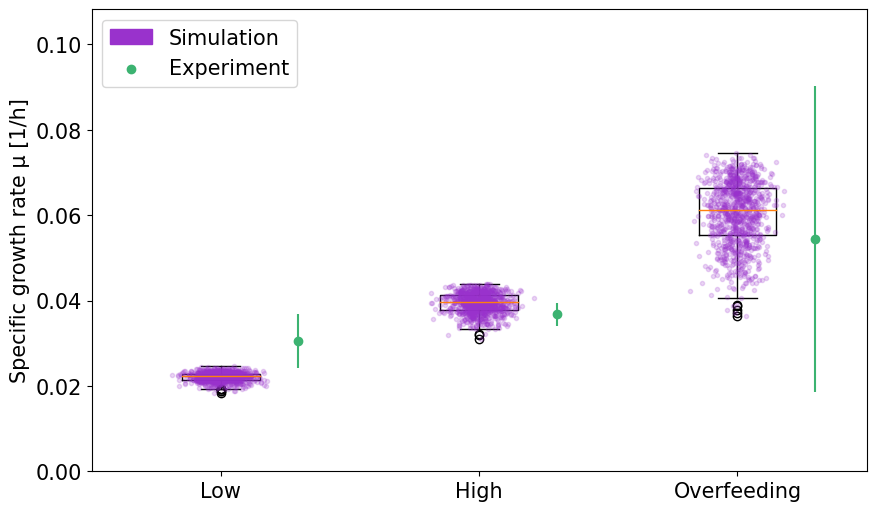

In [11]:
plot_sampling(growth_rates, rates_mean, rates_sd,
              "Growth rate µ", "Specific growth rate µ [1/h]")
plt.savefig("../figures/pFBA_sampled_growth_rate.jpg")

## Save data (unnormalized / normalized to biomass flux)

In [12]:
for condition, fluxes_one in fluxes.items():
    name = conditions[condition]
    fluxes_one["fluxes"] = fluxes_one.mean(axis=1)
    mapped_fluxes = get_central_fluxes(central_metabolism, fluxes_one)
    central_metabolism[f"{name}_pfba"] = mapped_fluxes

    # normalize by biomass flux (reaction ID: 0)
    central_metabolism[f"{name}_pfba_normalized"] = mapped_fluxes/fluxes_one.fluxes["0"]

In [13]:
central_metabolism.to_csv("../data/central_fluxes_pfba.csv")